In [73]:
from pyspark.sql import SparkSession

In [74]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mplsoccer import VerticalPitch
import seaborn as sns
from pyspark.sql.functions import format_number
import pyspark.sql.functions as F

In [75]:
spark = SparkSession.builder.appName("features").getOrCreate()

In [ ]:
hdfs_path = "hdfs://localhost:9000/user/aniss/events.csv"

# Load the CSV file into a DataFrame
events = spark.read.csv(hdfs_path, header=True, inferSchema=True)

In [50]:
shots = events.filter(events.type == 'Shot')

## Numerical Variables

### Location

In [51]:
shots.select('type','location','shot_statsbomb_xg').show(5,False)

+----+-------------+-----------------+
|type|location     |shot_statsbomb_xg|
+----+-------------+-----------------+
|Shot|[105.6, 44.0]|0.07213958       |
|Shot|[98.6, 25.2] |0.02977089       |
|Shot|[105.5, 47.3]|0.07589752       |
|Shot|[113.4, 38.7]|0.15686217       |
|Shot|[106.2, 36.8]|0.15133068       |
+----+-------------+-----------------+
only showing top 5 rows



## Categorical Variables

### Play pattern

In [71]:
# play_pattern unique values
shots.select('play_pattern').distinct().show()

+--------------+
|  play_pattern|
+--------------+
|  Regular Play|
|   From Keeper|
|From Goal Kick|
| From Throw In|
|         Other|
|   From Corner|
| From Kick Off|
|  From Counter|
|From Free Kick|
+--------------+



In [52]:
shots.select('type','play_pattern','shot_statsbomb_xg').show(5,False)

+----+-------------+-----------------+
|type|play_pattern |shot_statsbomb_xg|
+----+-------------+-----------------+
|Shot|From Kick Off|0.07213958       |
|Shot|From Keeper  |0.02977089       |
|Shot|From Throw In|0.07589752       |
|Shot|From Corner  |0.15686217       |
|Shot|From Throw In|0.15133068       |
+----+-------------+-----------------+
only showing top 5 rows



### Shot Type

In [ ]:
unique_shot_types = shots.select('type', 'shot_type', 'shot_statsbomb_xg').dropDuplicates(['shot_type'])
formatted_shot_types = unique_shot_types.withColumn(
    'shot_statsbomb_xg', format_number('shot_statsbomb_xg', 6))
formatted_shot_types.show(truncate=False)

+----+---------+-----------------+
|type|shot_type|shot_statsbomb_xg|
+----+---------+-----------------+
|Shot|Corner   |0.000180         |
|Shot|Free Kick|0.039566         |
|Shot|Open Play|0.072140         |
|Shot|Penalty  |0.783500         |
+----+---------+-----------------+



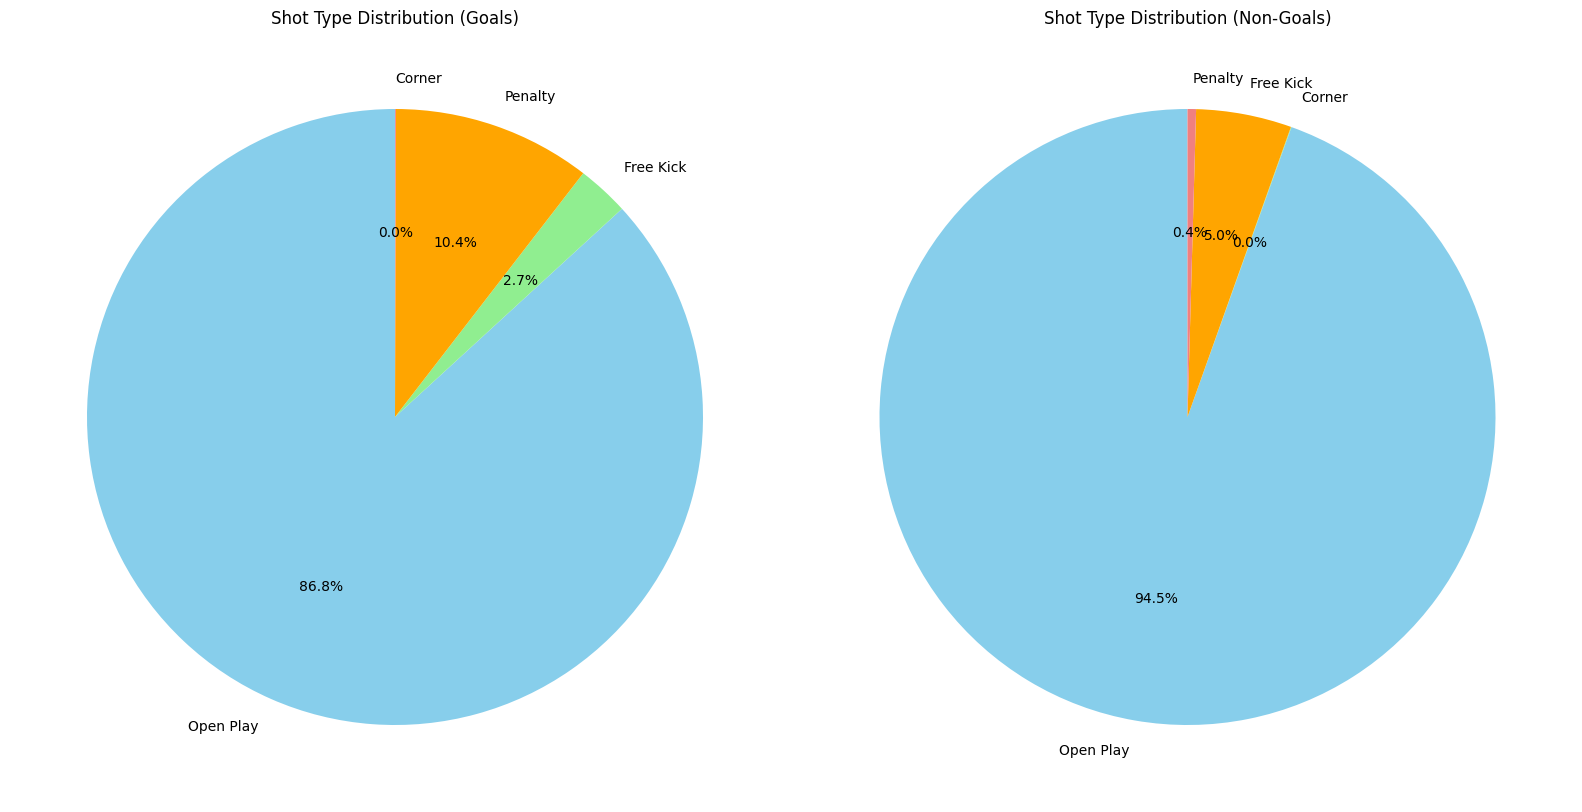

In [55]:
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

# Group by 'shot_type' for goals and non-goals
goal_shot_type_count = shots.filter(shots['shot_outcome'] == 'Goal').groupBy("shot_type").agg(F.count("shot_type").alias("count"))
non_goal_shot_type_count = shots.filter(shots['shot_outcome'] != 'Goal').groupBy("shot_type").agg(F.count("shot_type").alias("count"))

# Collect data for both goal and non-goal shots
goal_shot_type_data = goal_shot_type_count.collect()
non_goal_shot_type_data = non_goal_shot_type_count.collect()

# Prepare data for pie charts
goal_labels = [row['shot_type'] for row in goal_shot_type_data]
goal_sizes = [row['count'] for row in goal_shot_type_data]
non_goal_labels = [row['shot_type'] for row in non_goal_shot_type_data]
non_goal_sizes = [row['count'] for row in non_goal_shot_type_data]

# Create subplots for side-by-side pie charts
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Goal shot pie chart
axes[0].pie(
    goal_sizes,
    labels=goal_labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=['skyblue', 'lightgreen', 'orange', 'lightcoral'])
axes[0].set_title('Shot Type Distribution (Goals)')

# Non-goal shot pie chart
axes[1].pie(
    non_goal_sizes,
    labels=non_goal_labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=['skyblue', 'lightgreen', 'orange', 'lightcoral'])
axes[1].set_title('Shot Type Distribution (Non-Goals)')

# Show the pie charts
plt.tight_layout()
plt.show()

### Shot Body Part

In [16]:
shots.select('type','shot_body_part','shot_statsbomb_xg').show(5,False)

+----+--------------+-----------------+
|type|shot_body_part|shot_statsbomb_xg|
+----+--------------+-----------------+
|Shot|Right Foot    |0.07213958       |
|Shot|Right Foot    |0.02977089       |
|Shot|Right Foot    |0.07589752       |
|Shot|Head          |0.15686217       |
|Shot|Left Foot     |0.15133068       |
+----+--------------+-----------------+
only showing top 5 rows



In [17]:
shots.groupBy('shot_body_part').count().show()

+--------------+-----+
|shot_body_part|count|
+--------------+-----+
|    Right Foot|31623|
|     Left Foot|19880|
|          Head| 9922|
|         Other|  183|
+--------------+-----+



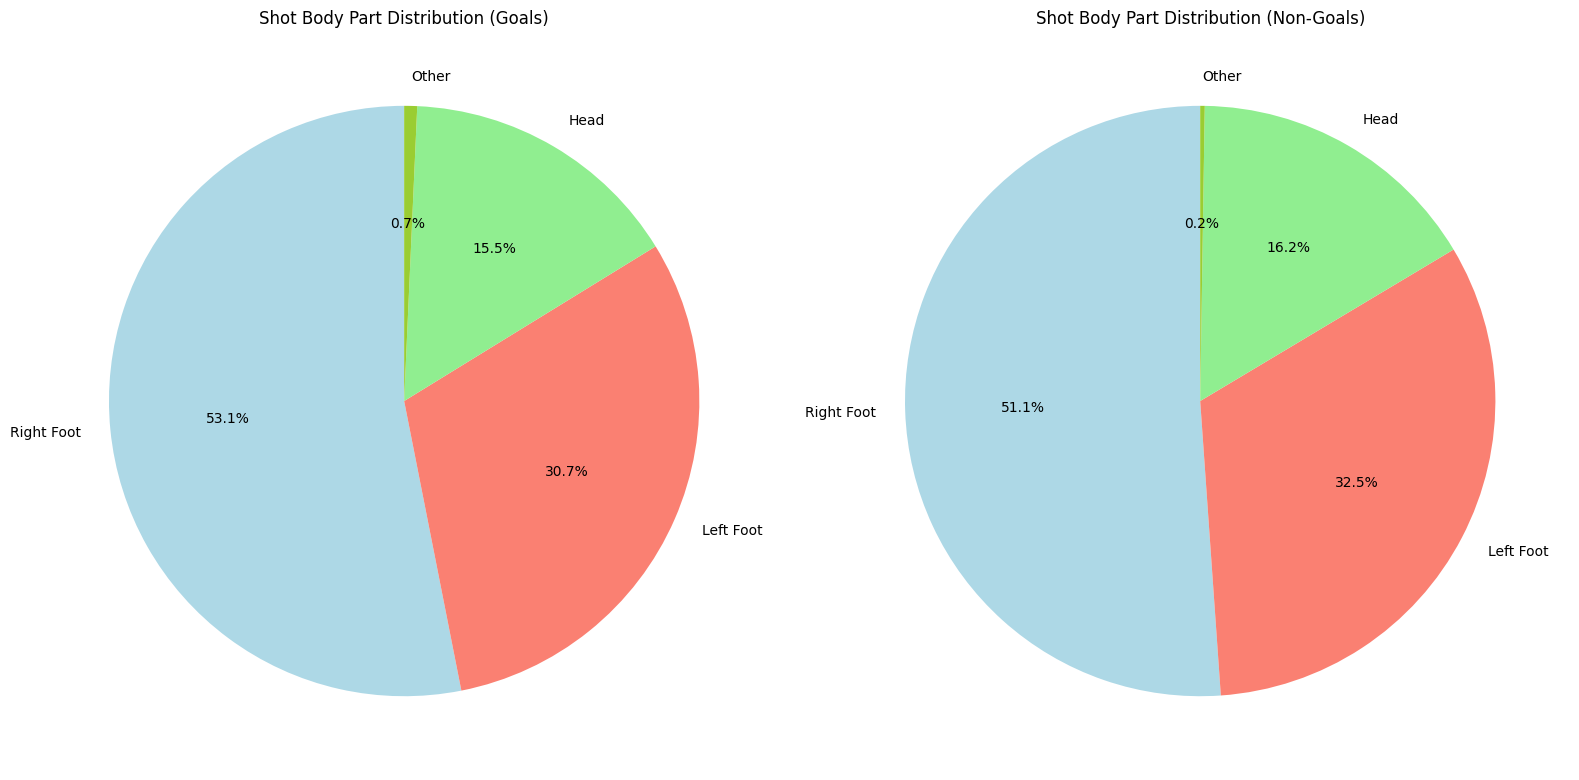

In [57]:
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

# Group by 'shot_body_part' for goals and non-goals
goal_shot_body_part_count = shots.filter(shots['shot_outcome'] == 'Goal').groupBy("shot_body_part").agg(F.count("shot_body_part").alias("count"))
non_goal_shot_body_part_count = shots.filter(shots['shot_outcome'] != 'Goal').groupBy("shot_body_part").agg(F.count("shot_body_part").alias("count"))

# Collect data for both goal and non-goal shots
goal_shot_body_part_data = goal_shot_body_part_count.collect()
non_goal_shot_body_part_data = non_goal_shot_body_part_count.collect()

# Prepare data for pie charts
goal_labels = [row['shot_body_part'] for row in goal_shot_body_part_data]
goal_sizes = [row['count'] for row in goal_shot_body_part_data]
non_goal_labels = [row['shot_body_part'] for row in non_goal_shot_body_part_data]
non_goal_sizes = [row['count'] for row in non_goal_shot_body_part_data]

# Create subplots for side-by-side pie charts
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Goal shot body part pie chart
axes[0].pie(
    goal_sizes,
    labels=goal_labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=['lightblue', 'salmon', 'lightgreen', 'yellowgreen'])
axes[0].set_title('Shot Body Part Distribution (Goals)')

# Non-goal shot body part pie chart
axes[1].pie(
    non_goal_sizes,
    labels=non_goal_labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=['lightblue', 'salmon', 'lightgreen', 'yellowgreen'])
axes[1].set_title('Shot Body Part Distribution (Non-Goals)')

# Show the pie charts
plt.tight_layout()
plt.show()

### Shot Technique

In [25]:
shots.select('type','shot_technique','shot_statsbomb_xg').show(5,False)

+----+--------------+-----------------+
|type|shot_technique|shot_statsbomb_xg|
+----+--------------+-----------------+
|Shot|Half Volley   |0.07213958       |
|Shot|Normal        |0.02977089       |
|Shot|Half Volley   |0.07589752       |
|Shot|Normal        |0.15686217       |
|Shot|Normal        |0.15133068       |
+----+--------------+-----------------+
only showing top 5 rows



In [26]:
shots.groupBy('shot_technique').count().show()

+--------------+-----+
|shot_technique|count|
+--------------+-----+
|      Backheel|  242|
| Diving Header|  239|
|   Half Volley| 8711|
| Overhead Kick|  351|
|        Volley| 4091|
|           Lob|  578|
|        Normal|47396|
+--------------+-----+



/tmp/ipykernel_92403/1159954305.py:6: FutureWarning:                            

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='shot_technique', y='shot_statsbomb_xg', data=goal_shots.toPandas(), palette='Set2')


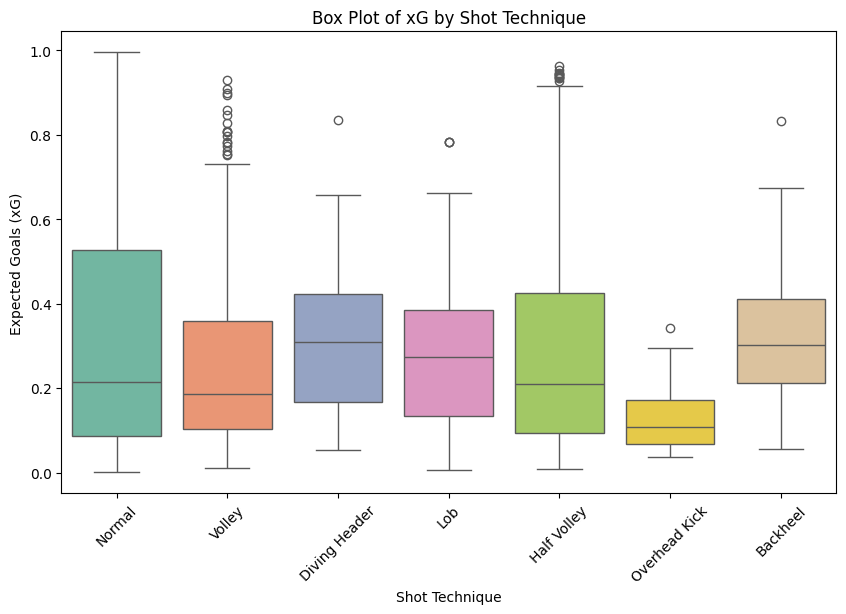

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt

goal_shots = shots.filter(shots['shot_outcome'] == 'Goal')

# Create the box plot for shot technique and xG distribution
plt.figure(figsize=(10, 6))
sns.boxplot(x='shot_technique', y='shot_statsbomb_xg', data=goal_shots.toPandas(), palette='Set2')
plt.title('Box Plot of xG by Shot Technique')
plt.xlabel('Shot Technique')
plt.ylabel('Expected Goals (xG)')
plt.xticks(rotation=45)
plt.show()

## Binary Variables

### Under Pressure

In [31]:
shots.select('type','under_pressure','shot_statsbomb_xg').show(5,False)

+----+--------------+-----------------+
|type|under_pressure|shot_statsbomb_xg|
+----+--------------+-----------------+
|Shot|NULL          |0.07213958       |
|Shot|NULL          |0.02977089       |
|Shot|true          |0.07589752       |
|Shot|true          |0.15686217       |
|Shot|NULL          |0.15133068       |
+----+--------------+-----------------+
only showing top 5 rows



### Shot First Time

In [39]:
shots.select('type','shot_first_time','shot_statsbomb_xg').show(5,False)

+----+---------------+-----------------+
|type|shot_first_time|shot_statsbomb_xg|
+----+---------------+-----------------+
|Shot|true           |0.07213958       |
|Shot|NULL           |0.02977089       |
|Shot|NULL           |0.07589752       |
|Shot|NULL           |0.15686217       |
|Shot|true           |0.15133068       |
+----+---------------+-----------------+
only showing top 5 rows



### Shot Aerial Won

In [41]:
shots.select('type','shot_aerial_won','shot_statsbomb_xg').show(5,False)

+----+---------------+-----------------+
|type|shot_aerial_won|shot_statsbomb_xg|
+----+---------------+-----------------+
|Shot|NULL           |0.07213958       |
|Shot|NULL           |0.02977089       |
|Shot|NULL           |0.07589752       |
|Shot|true           |0.15686217       |
|Shot|NULL           |0.15133068       |
+----+---------------+-----------------+
only showing top 5 rows



### Shot One on One

In [43]:
shots.select('type','shot_one_on_one','shot_statsbomb_xg').show(5,False)

+----+---------------+-----------------+
|type|shot_one_on_one|shot_statsbomb_xg|
+----+---------------+-----------------+
|Shot|NULL           |0.07213958       |
|Shot|NULL           |0.02977089       |
|Shot|NULL           |0.07589752       |
|Shot|NULL           |0.15686217       |
|Shot|NULL           |0.15133068       |
+----+---------------+-----------------+
only showing top 5 rows



### Shot Open Goal

In [44]:
shots.select('type','shot_open_goal','shot_statsbomb_xg').show(5,False)

+----+--------------+-----------------+
|type|shot_open_goal|shot_statsbomb_xg|
+----+--------------+-----------------+
|Shot|NULL          |0.07213958       |
|Shot|NULL          |0.02977089       |
|Shot|NULL          |0.07589752       |
|Shot|NULL          |0.15686217       |
|Shot|NULL          |0.15133068       |
+----+--------------+-----------------+
only showing top 5 rows



### Shot Follows Dribble

In [45]:
shots.select('type','shot_follows_dribble','shot_statsbomb_xg').show(5,False)

+----+--------------------+-----------------+
|type|shot_follows_dribble|shot_statsbomb_xg|
+----+--------------------+-----------------+
|Shot|NULL                |0.07213958       |
|Shot|NULL                |0.02977089       |
|Shot|NULL                |0.07589752       |
|Shot|NULL                |0.15686217       |
|Shot|NULL                |0.15133068       |
+----+--------------------+-----------------+
only showing top 5 rows



## Engineered Variables

In [6]:
import xG_preprocessing as pp

In [ ]:
shots_pp = pp.preprocessing(shots,spark)

In [ ]:
shots_pp = spark.read.csv('hdfs://localhost:9000/user/aniss/shots.csv',header=True,inferSchema=True)

In [35]:
# take a random shot from the dataset
row1 = shots_pp.filter(shots_pp['shot_outcome']=='Goal').filter(shots_pp['players_inside_area']>4).collect()[0]
row2 = shots_pp.filter(shots_pp['shot_outcome']=='Blocked').filter(shots_pp['players_inside_area']>3).collect()[0]
row3 = shots_pp.filter(shots_pp['shot_outcome']=='Off T').filter(shots_pp['players_inside_area']>=0).collect()[0]

### Scatter of xG by location x and y

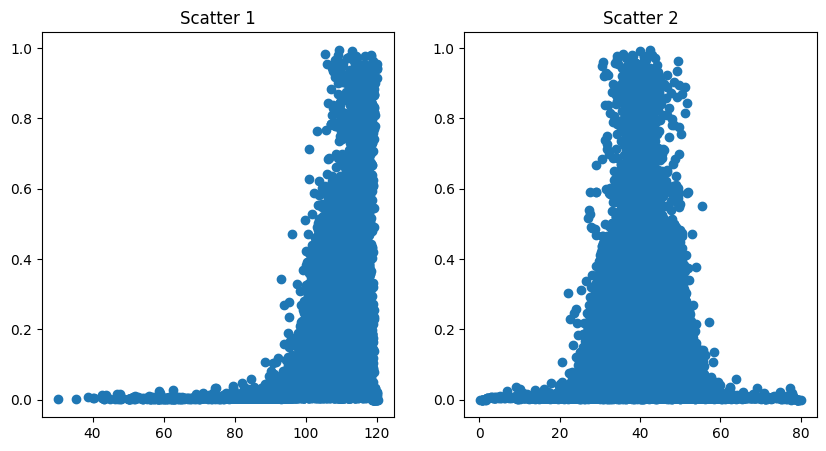

In [34]:
import matplotlib.pyplot as plt

x1 = shots_pp.select('shot_location_x').rdd.flatMap(lambda x: x).collect()
y1 = shots_pp.select('shot_statsbomb_xg').rdd.flatMap(lambda x: x).collect()

x2 = shots_pp.select('shot_location_y').rdd.flatMap(lambda x: x).collect()
y2 = shots_pp.select('shot_statsbomb_xg').rdd.flatMap(lambda x: x).collect()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# First scatter plot
axs[0].scatter(x1, y1)
axs[0].set_title('Scatter 1')

# Second scatter plot
axs[1].scatter(x2, y2)
axs[1].set_title('Scatter 2')

plt.show()

### Distance to goal

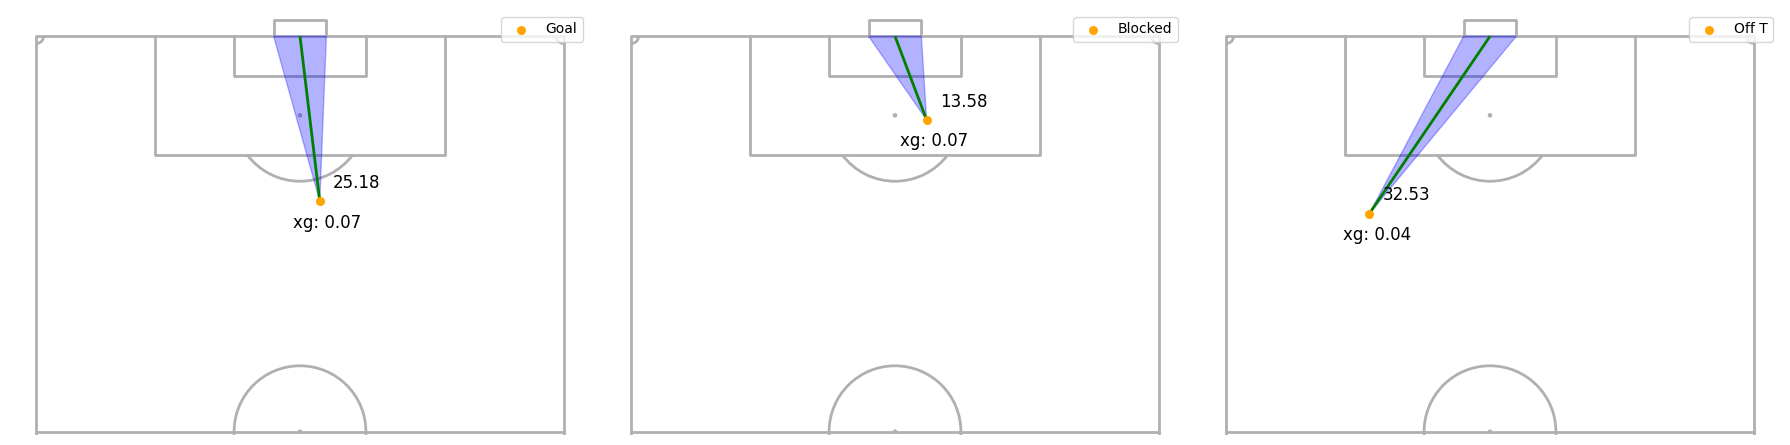

In [37]:
import matplotlib.pyplot as plt
from mplsoccer import VerticalPitch

rows = [row1, row2, row3]

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Loop through the rows and plot each shot on a separate subplot
for i, row in enumerate(rows):
    pitch = VerticalPitch(pad_bottom=0.5, pitch_type='statsbomb', half=True, corner_arcs=True, goal_type='box')
    
    ax = axes[i]
    
    # Draw the pitch
    pitch.draw(ax=ax)
    
    # Draw the goal angle area
    pitch.goal_angle(x=row['shot_location_x'], y=row['shot_location_y'], goal='right', ax=ax, color='blue', alpha=0.3, zorder=1)
    
    # Draw the line for the shot distance
    pitch.lines(xstart=row['shot_location_x'], ystart=row['shot_location_y'], xend=120, yend=40, ax=ax, lw=2, color='green')
    
    # Scatter plot for the shot location
    pitch.scatter(row['shot_location_x'], row['shot_location_y'], color='orange', s=30, label=row['shot_outcome'], ax=ax, zorder=2)
    # Annotate shot angle
    pitch.annotate(str(round(row['distance_to_goal'], 2)), (row['shot_location_x'] + 2, row['shot_location_y'] + 2), ax=ax, zorder=3, fontsize=12)
    pitch.annotate('xg: '+str(round(row['shot_statsbomb_xg'], 2)), (row['shot_location_x'] - 4, row['shot_location_y'] - 4), ax=ax, zorder=3, fontsize=12)

    # Set the legend
    ax.legend(loc='upper right')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

### Angle to goal

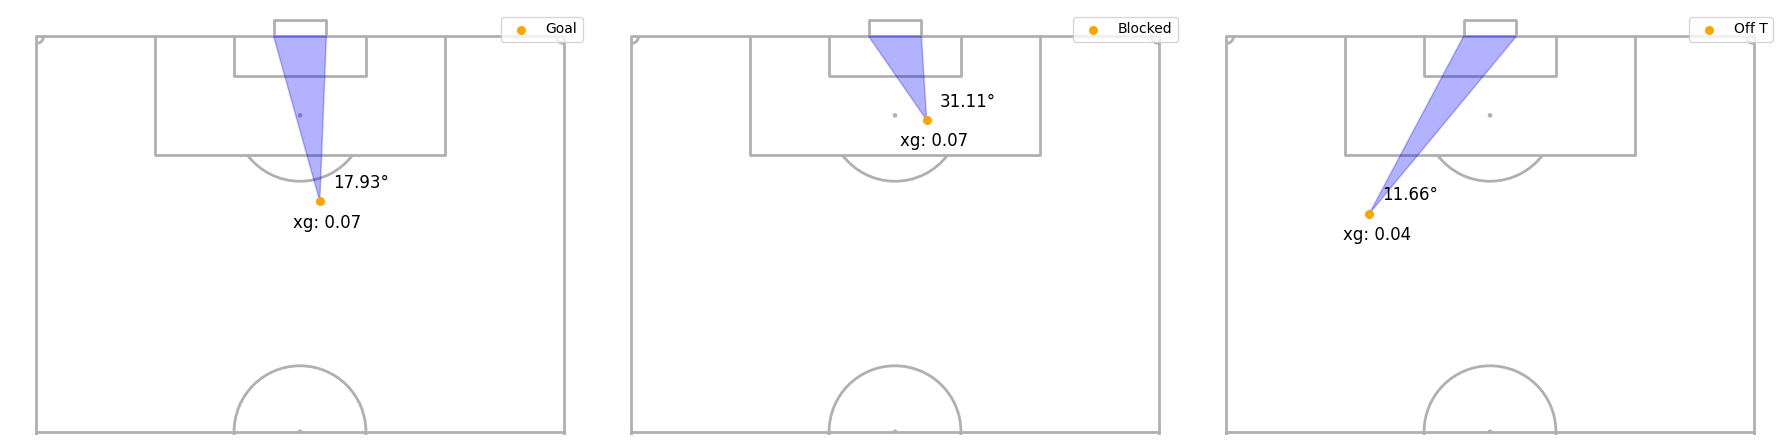

In [38]:
import matplotlib.pyplot as plt
from mplsoccer import VerticalPitch

rows = [row1, row2, row3]

# Create a figure with 3 subplots (side by side)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Loop through the rows and plot each shot on a separate subplot
for i, row in enumerate(rows):
    pitch = VerticalPitch(pad_bottom=0.5, pitch_type='statsbomb', half=True, corner_arcs=True, goal_type='box')
    
    ax = axes[i]
    
    # Draw the pitch
    pitch.draw(ax=ax)
    
    # Draw the goal angle area
    pitch.goal_angle(x=row['shot_location_x'], y=row['shot_location_y'], goal='right', ax=ax, color='blue', alpha=0.3, zorder=1)
    
    # Scatter plot for the shot location
    pitch.scatter(row['shot_location_x'], row['shot_location_y'], color='orange', s=30, label=row['shot_outcome'], ax=ax, zorder=2)
    
    # Annotate shot angle
    pitch.annotate(str(round(row['shot_angle'], 2)) + "°", (row['shot_location_x'] + 2, row['shot_location_y'] + 2), ax=ax, zorder=3, fontsize=12)
    pitch.annotate('xg: '+str(round(row['shot_statsbomb_xg'], 2)), (row['shot_location_x'] - 4, row['shot_location_y'] - 4), ax=ax, zorder=3, fontsize=12)

    # Set the legend
    ax.legend(loc='upper right')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

### Players Inside Area

In [45]:
shot_freeze_frame1 = pp.shot_frame_to_df(events.filter(events['id']==row1['id']))
shot_freeze_frame2 = pp.shot_frame_to_df(events.filter(events['id']==row2['id']))
shot_freeze_frame3 = pp.shot_frame_to_df(events.filter(events['id']==row3['id']))

In [46]:
shot_freeze_frame2

,Shot_id,x,y,position,teammate
0,7373e8da-62d6-48a5-b8df-5c50fae624e6,112.1,60.1,Left Wing Back,False
1,7373e8da-62d6-48a5-b8df-5c50fae624e6,108.6,48.1,Left Defensive Midfield,False
2,7373e8da-62d6-48a5-b8df-5c50fae624e6,107.9,43.4,Right Defensive Midfield,False
3,7373e8da-62d6-48a5-b8df-5c50fae624e6,112.4,44.3,Left Center Back,False
4,7373e8da-62d6-48a5-b8df-5c50fae624e6,102.0,28.6,Right Wing,False
5,7373e8da-62d6-48a5-b8df-5c50fae624e6,113.3,41.6,Center Back,False
6,7373e8da-62d6-48a5-b8df-5c50fae624e6,112.9,35.9,Right Center Back,False
7,7373e8da-62d6-48a5-b8df-5c50fae624e6,109.5,26.0,Right Wing Back,False
8,7373e8da-62d6-48a5-b8df-5c50fae624e6,119.2,41.8,Goalkeeper,False
9,7373e8da-62d6-48a5-b8df-5c50fae624e6,94.8,53.7,Right Defensive Midfield,True


In [47]:
sff_c1 = shot_freeze_frame1[shot_freeze_frame1['teammate']=='True']
sff_o1 = shot_freeze_frame1[shot_freeze_frame1['teammate']=='False']
sff_c2 = shot_freeze_frame2[shot_freeze_frame2['teammate']=='True']
sff_o2 = shot_freeze_frame2[shot_freeze_frame2['teammate']=='False']
sff_c3 = shot_freeze_frame3[shot_freeze_frame3['teammate']=='True']
sff_o3 = shot_freeze_frame3[shot_freeze_frame3['teammate']=='False']

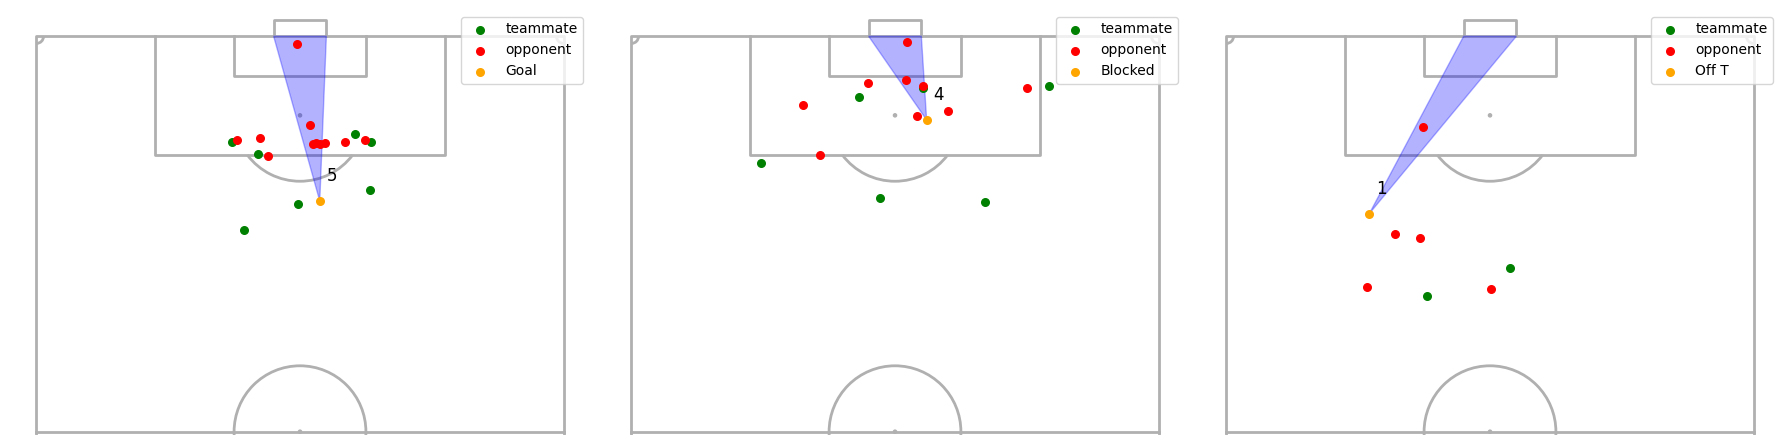

In [48]:
import matplotlib.pyplot as plt
from mplsoccer import VerticalPitch

rows = [row1, row2, row3]
sff_c = [sff_c1, sff_c2, sff_c3]  # List of teammate coordinates for each row
sff_o = [sff_o1, sff_o2, sff_o3]  # List of opponent coordinates for each row

# Create a figure with 3 subplots (side by side)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Loop through the rows and plot each shot on a separate subplot
for i, row in enumerate(rows):
    pitch = VerticalPitch(pad_bottom=0.5, pitch_type='statsbomb', half=True, corner_arcs=True, goal_type='box')
    
    ax = axes[i]
    
    # Draw the pitch
    pitch.draw(ax=ax)
    
    # Draw the goal angle area
    pitch.goal_angle(x=row['shot_location_x'], y=row['shot_location_y'], goal='right', ax=ax, color='blue', alpha=0.3, zorder=1)
    
    # Scatter plot for the teammates
    c = pitch.scatter(sff_c[i]['x'], sff_c[i]['y'], color='green', s=30, label='teammate', ax=ax, zorder=2)
    
    # Scatter plot for the opponents
    o = pitch.scatter(sff_o[i]['x'], sff_o[i]['y'], color='red', s=30, label='opponent', ax=ax, zorder=2)
    
    # Scatter plot for the shot location
    sc1 = pitch.scatter(row['shot_location_x'], row['shot_location_y'], color='orange', s=30, label=row['shot_outcome'], ax=ax, zorder=2)
    
    # Annotate the number of players inside the area
    an = pitch.annotate(row['players_inside_area'], (row['shot_location_x'] + 3, row['shot_location_y'] + 1), ax=ax, zorder=3, fontsize=12)
    
    # Set the legend
    ax.legend(loc='upper right')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

### Pitch Visualization

In [56]:
df = events.toPandas()
# Set random seed for reproducibility
np.random.seed(42)

# Step 1: K-means clustering
k = 40  # Number of clusters
X = df[['shot_location_x', 'shot_location_y']].values

# Make KMeans reproducible
kmeans = KMeans(n_clusters=k, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

In [57]:
# Step 2: Sample from each cluster
sampled_df = df.groupby('cluster').apply(lambda x: x.sample(min(len(x), 25)))  # Sampling 25 shots per cluster, adjust as needed

# Check if the number of samples is greater than or equal to 3000
if len(sampled_df) > 1000:
    sampled_df = sampled_df.sample(n=1000, random_state=42)  # Get exactly 3000 samples
else:
    print(f"Number of samples is {len(sampled_df)}, which is less than 3000.")

Number of samples is 1000, which is less than 3000.


/tmp/ipykernel_31367/1546939458.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby('cluster').apply(lambda x: x.sample(min(len(x), 25)))  # Sampling 25 shots per cluster, adjust as needed


In [58]:
sampled_df_g = sampled_df[sampled_df['goal'] == 1]
sampled_df_ng = sampled_df[sampled_df['goal'] == 0]

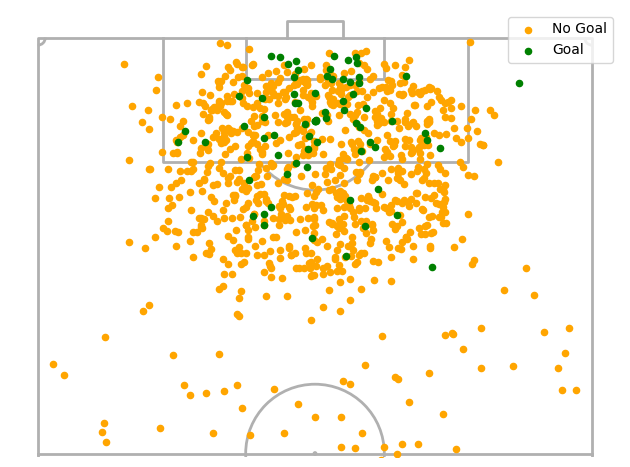

In [59]:
# Step 3: Plotting the representative sample on the pitch
# Fix figure size for consistency
pitch = VerticalPitch(pad_bottom=0.5, pitch_type='statsbomb', half=True, corner_arcs=True, goal_type='box')

# Draw pitch and scatter shots
fig, ax = pitch.draw()

sc1 = pitch.scatter(sampled_df_ng['shot_location_x'],
                    sampled_df_ng['shot_location_y'],
                    color='orange',
                    s=20,
                    label='No Goal',
                    ax=ax)

sc2 = pitch.scatter(sampled_df_g['shot_location_x'],
                    sampled_df_g['shot_location_y'],
                    color='green',
                    s=20,
                    label='Goal',
                    ax=ax)

# Add a legend in a fixed position
ax.legend(loc='upper right')

# Ensure consistent display
plt.tight_layout()
plt.show()